In [8]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import cv2               as cv

import os
from os.path                  import join, dirname, abspath

import io
import PIL
import tensorflow        as tf


from tensorflow               import keras
from tensorflow.keras         import layers
from tensorflow.keras.models  import Sequential
from PIL                      import ImageChops
from google.cloud             import storage
from mushroom_learning.params import BUCKET_NAME, STORAGE_LOCATION


import pathlib
from dotenv import load_dotenv, find_dotenv

In [9]:
# Api imports
import requests

In [10]:
import pathlib


def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

# Look at directory

In [11]:
! pwd
! ls -rtlh ../raw_data/fungi_identification/images/

/home/noel/code/DSP-Tan/mushroom_learning/notebooks
total 7.5M
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  41004_Calocybe_ionides
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  41002_Calocybe_carnea
drwxr-xr-x 2 noel noel  20K Mar 27  2018  40985_Byssomerulius_corium
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16435_Aspropaxillus_giganteus
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16423_Leucogyrophana_mollusca
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16411_Leucocoprinus_brebissonii
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16390_Leucoagaricus_leucothites
drwxr-xr-x 2 noel noel  12K Mar 27  2018  65745_Suillellus_luridus
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16593_Lycoperdon_lividum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16588_Lycoperdon_echinatum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16587_Lycoperdon_decipiens
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16582_Lycogala_flavofuscum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16580_Lycogala_epidendrum
drwxr-xr-x 2 noel noel 4.0K Mar 27  20

## Find number of species

### linux method

In [12]:
ls -rtlh ../raw_data/fungi_identification/images/ | wc

   1395   12548  112471


In [13]:
num_species=1395

### Python method

In [14]:
import os, sys

path_to_imgs='../raw_data/fungi_identification/images/'

# listing directories
species_dir_list=os.listdir(path_to_imgs)

# renaming directory 
#os.rename("old_name","new_name")
# you can list again after if you like

In [15]:
species_dir_list[1]

'11317_Cantharellus_cibarius'

#### check for spaces in names

In [16]:
for i in species_dir_list:
    if ' ' in i:
        print(i)

**There are none**

#### Get rid of spaces in directory names

In [17]:
for i in species_dir_list:
    if ' ' in i:
        mytable = i.maketrans(" ", "_")
        i_new=i.translate(mytable)
        os.rename(path_to_imgs+i,path_to_imgs+i_new)

In [18]:
#### Count number of species

In [19]:
print(f'We have {len(species_dir_list)} different species')

We have 1394 different species


In [20]:
def find_species(species_name,species_list):
    '''
    This takes a species name as a string, which should have an _ between the genus and species,
    and returns its containing directory to you. It must 
    '''
    for i in species_list:
        if species_name.lower() in i.lower():
            return path_to_imgs+i

In [21]:
amanites=find_species('amanita_muscaria',species_dir_list)
print(amanites)

../raw_data/fungi_identification/images/10252_Amanita_muscaria


## Find number of photos of each species

In [22]:
def num_of_species(spec_dir):
    return len( list(os.listdir(spec_dir)) )

In [23]:
num_of_species(find_species('amanita_muscaria',species_dir_list))

163

In [24]:
!pwd

/home/noel/code/DSP-Tan/mushroom_learning/notebooks


In [25]:
spec='species'
num='num'
#print(f'{spec:30} {num:30}')
spec_names=[]
spec_num_phots=[]
for i in species_dir_list:
    #This skips the files folder_analysis.sh and folders.txt which are here and are not directories.
    if 'folder' in i:
        continue
    #print(f'{i:50} {len(list(os.listdir(path_to_imgs+i)))}')
    spec_names.append(i)
    spec_num_phots.append(len(list(os.listdir(path_to_imgs+i))))
    
zipped = list(zip(spec_names, spec_num_phots))
df = pd.DataFrame(zipped, columns=['Name', '# photos'])
df.head()

Name  # photos
0   67237_Hortiboletus_engelii        64
1  11317_Cantharellus_cibarius       144
2     20739_Suillus_variegatus        50
3          13953_Exidia_pithya        21
4  14815_Hygrocybe_acutoconica       143

### Identify top 20 for choice of what species to detect. 

In [26]:
df.sort_values('# photos',ascending=False).head(20)

Name  # photos
648             18882_Plicatura_crispa       442
875             18890_Pluteus_cervinus       419
1000     21143_Tricholoma_scalpturatum       414
21     11082_Xerocomellus_chrysenteron       406
1195         17233_Mycena_galericulata       375
768         40985_Byssomerulius_corium       374
416       12919_Cylindrobasidium_laeve       364
760             40392_Armillaria_lutea       352
364          14160_Ganoderma_pfeifferi       342
814         61207_Coprinellus_micaceus       340
933          14064_Fomitopsis_pinicola       329
884          20983_Trametes_versicolor       313
612            14062_Fomes_fomentarius       308
927      19105_Psathyrella_candolleana       298
847            67679_Xylodon_paradoxus       291
991        15078_Hypholoma_fasciculare       289
151   10934_Auricularia_auricula-judae       285
1286            16111_Leccinum_scabrum       278
92          14158_Ganoderma_applanatum       265
1006       40854_Xerocomus_ferrugineus       255

In [27]:
data_dir=get_images_directory('../raw_data/fungi_identification/images/')

In [28]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

89760


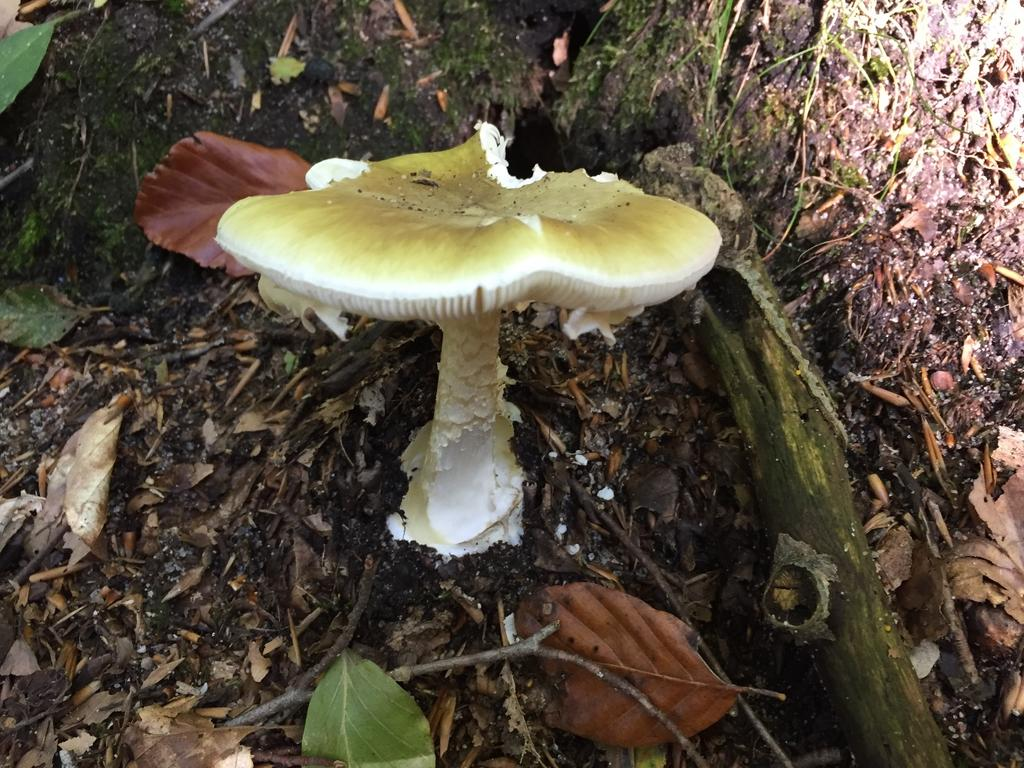

In [29]:
death_caps= list(data_dir.glob('63478_Amanita_phalloides/*'))
PIL.Image.open(str(death_caps[11]))

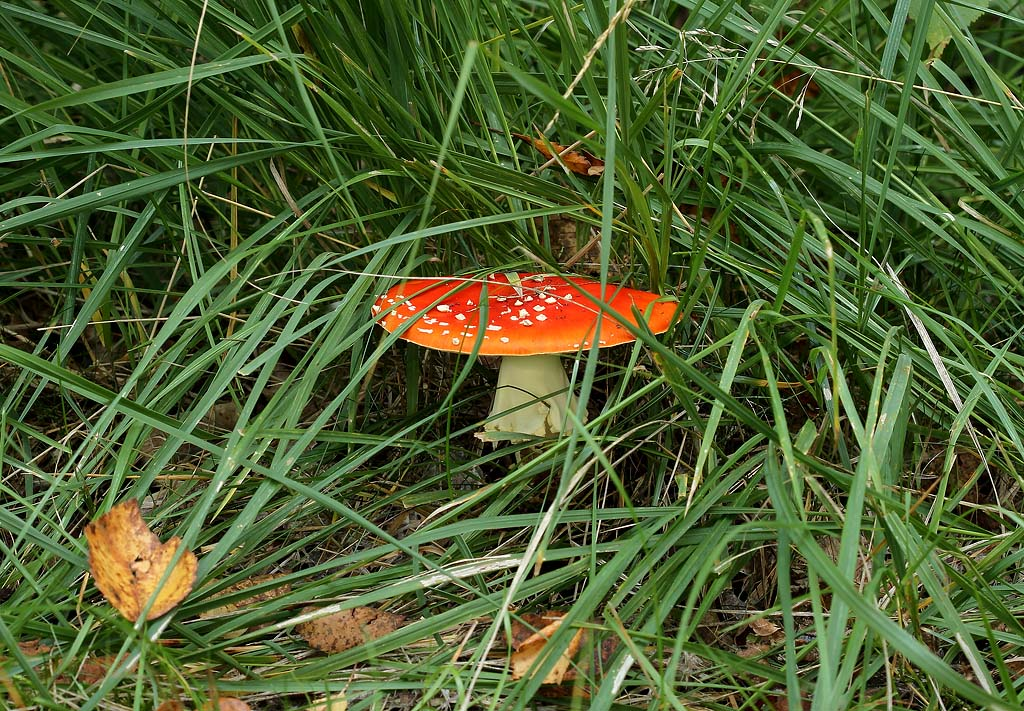

In [30]:
# fly_agaric is the common name for Amanita_muscaria
fly_agarics = list(data_dir.glob('10252_Amanita_muscaria/*'))
PIL.Image.open(str(fly_agarics[5]))

In [31]:
#! ls -rtlh '../raw_data/fungi_identification/images/10000_Abortiporus_biennis/'

In [32]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

In [33]:
death_caps[0]

PosixPath('../raw_data/fungi_identification/images/63478_Amanita_phalloides/MIH2001-9191788_ByxTxrRNyb.JPG')

# Getting images into API and Streamlit

In [34]:
from fastapi import FastAPI, File, UploadFile

In [35]:
image=PIL.Image.open(death_caps[0])
print(type(image))
image_array = np.array(image)
print(image_array.shape)
print(f'So every row has 1024 columns, each with a depth of 3, total elements:{657*1024*3}')
print(f'\nThese are not bytes, as this does not bear a fixed relation to the filesize: {2018304/59836}')

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(657, 1024, 3)
So every row has 1024 columns, each with a depth of 3, total elements:2018304

These are not bytes, as this does not bear a fixed relation to the filesize: 33.73059696503777


## Open the image as bytes to get a feel for how Fast API does it.

In [36]:
with open(death_caps[0], 'rb') as f:
    byte_im = f.read()
byte_im_array=np.asarray(bytearray(byte_im), dtype="uint8")
print(f'The size is {len(byte_im_array)/1000}K, the shape is {byte_im_array.shape}')
print(f'The type is {type(byte_im_array)}')


The size is 59.836K, the shape is (59836,)
The type is <class 'numpy.ndarray'>


In [37]:
print('Confirm size using ls:')
!ls -rtlh \
'../raw_data/fungi_identification/images/63478_Amanita_phalloides/MIH2001-9191788_ByxTxrRNyb.JPG' \
| awk '{print $5}'

Confirm size using ls:
59K


### Trying to reshape this using just numpy doesn't work for some reason.

In [38]:
# X=np.reshape(byte_im_array,(224, 224, 3))
# plt.imshow(X);
print('This gives this error:\nValueError: cannot reshape array of size 59836 into shape (224,224,3)')

This gives this error:
ValueError: cannot reshape array of size 59836 into shape (224,224,3)


### But we can reshape it with cv.imdecode as Stella did.

The type of this is: <class 'numpy.ndarray'>; it's shape is (657, 1024, 3)


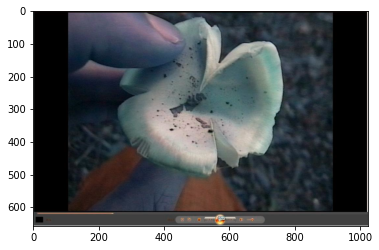

In [39]:
decode_img = cv.imdecode(byte_im_array,cv.IMREAD_COLOR)
print(f"The type of this is: {type(decode_img)}; it's shape is {decode_img.shape}")
plt.imshow(decode_img);

#### CV uses BGR and not RGB order, must correct this

See here:
https://stackoverflow.com/questions/52494592/wrong-colours-with-cv2-imdecode-python-opencv <br>
**matplotlib requires RGB ordering whereas OpenCV (perversely) uses BGR. I think you need to use cv2.cvtColor() to convert between the two.**

The type of this is: <class 'numpy.ndarray'>; it's shape is (657, 1024, 3)


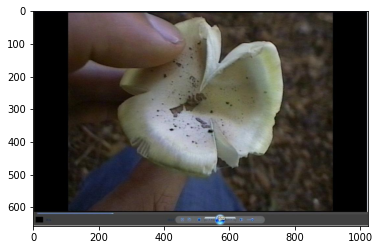

In [40]:
imageRGB = cv.cvtColor(decode_img , cv.COLOR_BGR2RGB)
print(f"The type of this is: {type(imageRGB)}; it's shape is {imageRGB.shape}")

plt.imshow(imageRGB);

### Let's do another way and see if they are different

The type of this is: <class 'PIL.JpegImagePlugin.JpegImageFile'>


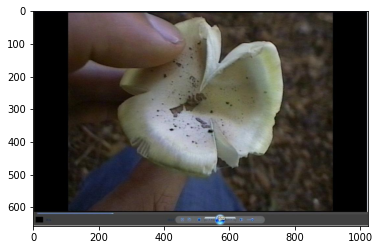

In [41]:
decode_img2 = PIL.Image.open(io.BytesIO(byte_im_array))
print(f"The type of this is: {type(decode_img2)}")
plt.imshow(decode_img2);

The type of this is: <class 'numpy.ndarray'>; it's shape is (657, 1024, 3)


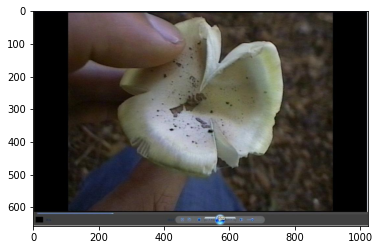

In [42]:
decode_img2_arr = np.asarray(decode_img2)
print(f"The type of this is: {type(decode_img2_arr)}; it's shape is {decode_img2_arr.shape}")
plt.imshow(decode_img2_arr);

In [43]:
#imageRGB==decode_img2_arr
np.array_equal(imageRGB, decode_img2_arr, equal_nan=False)

True

### Finally let's reshape it again with Keras so that it can get into Laura's model

#### Laura loads an image from a path and reshapes it in the loading

The type of this loaded image is: <class 'PIL.JpegImagePlugin.JpegImageFile'>


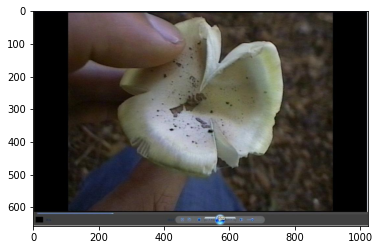

In [44]:
# Load with reshaping
img_height = 224
img_width  = 224
model_img_resize  = tf.keras.utils.load_img(death_caps[0], target_size=(img_height, img_width))

# Load without reshaping.
model_img  = tf.keras.utils.load_img(death_caps[0])
print(f'The type of this loaded image is: {type(model_img)}')
plt.imshow(model_img);

#### Use ImageChops from PIL library to compare this with our earlier PIL image

In [45]:
diff = ImageChops.difference(model_img, decode_img2)
if diff.getbbox():
    print("images are different")
else:
    print("images are the same")

images are the same


 <span style="color:blue"><span style="font-family:Papyrus; font-size:2em;">The images will be the same if we do not apply any reshaping. It is just that when you load in and reshape with keras, it does some interpolation.</span> </span>

#### We however do not want to do it this way, but to use an existing image.

In [46]:
img_height = 224
img_width  = 224
size=(img_width,img_height)

model_img_resize  = tf.keras.utils.load_img(death_caps[0], target_size=size)
print(type(model_img_resize))
decode_img2_resize=decode_img2.resize(size)
print(type(decode_img2_resize))

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


In [47]:
diff = ImageChops.difference(model_img_resize, decode_img2_resize)
if diff.getbbox():
    print("images are different")
else:
    print("images are the same")

images are different


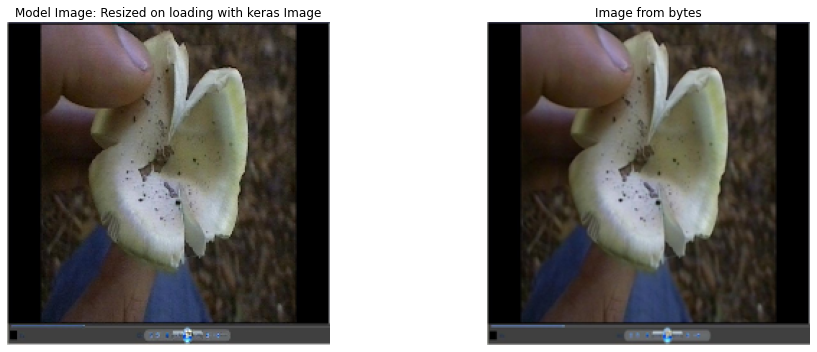

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].imshow(model_img_resize)
ax[0].set_title('Model Image: Resized on loading with keras Image')

ax[1].imshow(decode_img2_resize)
ax[1].set_title('Image from bytes')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

**They don't look different to me**

In [85]:
print(type(decode_img2))
tf_resized_img=tf.image.resize(decode_img2,size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
print(type(tf_resized_img))
tf_resized_img_np=np.array(tf_resized_img)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [50]:
print(tf_resized_img_np.shape)
np.array_equal(tf_resized_img_np, np.asarray(model_img_resize), equal_nan=False)

(224, 224, 3)


False

In [51]:
print(tf_resized_img_np.shape)
print(np.asarray(model_img_resize).shape)

(224, 224, 3)
(224, 224, 3)


# Passing image to model for prediction

## Load Model locally

### Load model

In [141]:
!ls -rtlh ../our_first_modelmodels_first_model
!ls -rtlh ../our_first_model/saved_model.pb

model=keras.models.load_model('../our_first_model/')
model

-rw-r--r-- 1 noel noel 18 Mar  3 18:08 ../our_first_modelmodels_first_model
-rw-r--r-- 1 noel noel 389K Mar  3 18:08 ../our_first_model/saved_model.pb


**Note that we just specify the directory of the model, not the model itself. Either there is some internal variable which was set which tells it the name of the model to load, or else you can only have one model per directory, and it must always be named "saved_model.pb"**

### Run with image loaded exactly as Laura does

In [138]:
class_names = ['Edible', 'Poisonous']
size=(224,224)

head1='step'; head2='type'; head3='shape'
print(f'{head1:26} {head2:56} {head3:30}')

img_L  = tf.keras.utils.load_img(death_caps[0], target_size=size)
im_type=type(img_L); shape=img_L.size; descrip='Keras loaded resized image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

img_L = tf.keras.utils.img_to_array(img_L)
im_type=type(img_L); shape=img_L.size; descrip='Converted to np array'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

img_L = tf.expand_dims(img_L, 0) # Create a batch
im_type=type(img_L); shape=img_L.shape; descrip='Tensorflow expanded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

print('\n')
prediction = model.predict(img_array)
print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.5f}")

step                       type                                                     shape                         
Keras loaded resized image <class 'PIL.Image.Image'>                                (224, 224)                    
Converted to np array      <class 'numpy.ndarray'>                                  150528                        
Tensorflow expanded image  <class 'tensorflow.python.framework.ops.EagerTensor'>    (1, 224, 224, 3)              


This image most likely belongs to Poisonous with a score of: 0.61699


### Run with image as it will arrive in API

In [139]:
# Get bunch of bites and look at size etc.
with open(death_caps[0], 'rb') as f:
    im_API = f.read()
im_API=np.asarray(bytearray(im_API), dtype="uint8")
print(f'The size of the file is {len(im_API)/1000}K\n') 


head1='step'; head2='type'; head3='shape'
print(f'{head1:26} {head2:56} {head3:30}')

im_type=type(im_API); shape=im_API.size; descrip='Image from API as bytes'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')


# decode these back into image form with cv.imdecode
im_API = cv.imdecode(im_API,cv.IMREAD_COLOR)
# cv.imdecode uses BGR and not RGB so we must adjust this using cv.cvtColor
im_API = cv.cvtColor(im_API , cv.COLOR_BGR2RGB)
im_type=type(im_API); shape=im_API.shape; descrip='CV Decoded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')



# resize using tensor flows resize with nearest neighbour interpolation to be similar to 
# what is done with that loading function. Though we know there remains some difference.
im_API=tf.image.resize(im_API,size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
im_type=type(im_API); shape=im_API.shape; descrip='Tensorflow resized image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')

im_API = tf.expand_dims(im_API, 0) # Create a batch
im_type=type(im_API); shape=im_API.shape; descrip='Tensorflow expanded image'
print(f'{descrip:26} {str(im_type):56} {str(shape):30}')


print('\n')
prediction = model.predict(im_API)
print(f"This image most likely belongs to {class_names[classif]} with a score of: {prediction[0][0]:.5f}")

The size of the file is 59.836K

step                       type                                                     shape                         
Image from API as bytes    <class 'numpy.ndarray'>                                  59836                         
CV Decoded image           <class 'numpy.ndarray'>                                  (657, 1024, 3)                
Tensorflow resized image   <class 'tensorflow.python.framework.ops.EagerTensor'>    (224, 224, 3)                 
Tensorflow expanded image  <class 'tensorflow.python.framework.ops.EagerTensor'>    (1, 224, 224, 3)              


This image most likely belongs to Poisonous with a score of: 0.61699


## Load from gcp

In [54]:
from mushroom_learning.gcp import load_from_gcp

 <span style="color:blue"><span style="font-family:Papyrus; font-size:2em;">We will put the .env file in our notebooks folder here. DONT FORGET TO DELETE.</span> </span>

In [64]:
print(os.environ['gcp_json_path'])
storage_client = storage.Client.from_service_account_json(os.getenv("gcp_json_path"))

/home/noel/Bureau/omega-clarity-337815-7177e76f8542.json


In [78]:
#model = load_from_gcp()
print('This gives this error')
print("RefreshError: ('invalid_grant: Invalid JWT Signature.', {'error': 'invalid_grant', 'error_description': 'Invalid JWT Signature.'})")

This gives this error
RefreshError: ('invalid_grant: Invalid JWT Signature.', {'error': 'invalid_grant', 'error_description': 'Invalid JWT Signature.'})


https://medium.com/google-cloud/jwt-json-web-tokens-errors-invalid-jwt-signature-8aab13703eb5

When we look at this function, it seems it is not loading it from GCP anyway. It loads it from local storage using this function.

In [66]:
LOCAL_STORAGE_PATH =  "../our_first_model"
def get_model():
        print(LOCAL_STORAGE_PATH)
        return keras.models.load_model(LOCAL_STORAGE_PATH)
model=get_model()

[[0.61826456]]
1
This image most likely belongs to Poisonous with a score of: 0.62
